In [1]:
from pyfilterbank import gammatone
from matplotlib import pyplot as plt
import signal

b,a = gammatone.design_filter(
    sample_rate=44100,
    order=32,
    centerfrequency=1000.0,
    band_width=None,
    band_width_factor=1.0,
    attenuation_half_bandwidth_db=-3,
)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print(torch.__version__)

import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..")))
from tools import plot, utils
from tools.nn_modules import *
import numpy as np

import IPython.display as ipd

2.1.0+cpu


In [3]:
# helper functions

def plot_time_and_spec(signals, samplerate, labels):
    
    freq_axes = []
    spec_axes = []
    for signal in signals:
        h, f = utils.get_spectrum(signal, samplerate=samplerate)
        freq_axes.append(f)
        spec_axes.append(h)

    # Plot IR in time-domain and magnitude repsonse
    plot.timeseries(
        signals, samplerate=samplerate, title="Input-output signals", labels=labels
    )
    plot.magspec(
        freq_axes=freq_axes, spec_axes=spec_axes, title="Spectra", labels=labels
    )


def batch_2_np(batch):
    return batch[0][0].detach().numpy()


def audio_play(signal, samplerate):
    return ipd.display(ipd.Audio(signal, rate=samplerate))  # load a NumPy array

In [50]:
# define parameters
samplerate = 22050
center_frequencies = [1000]
n_batch = 1
n_samples = 22050
n_channels = 1
taps = 128

In [48]:
from scipy import signal
import numpy as np


def plot_gammabank(bank, center_frequencies, samplerate):
    freq_axes = []
    spec_axes = []
    for filter in bank.filters:
        w, h = signal.freqz(filter.b, filter.a,worN=len(filter.b))
        f = w / (2*pi)  * samplerate
        freq_axes.append(f)
        spec_axes.append(h)

    # Plot IR in time-domain and magnitude repsonse
    plot.magspec(
        freq_axes=freq_axes,
        spec_axes=spec_axes,
        title="Magnitude response",
        labels=center_frequencies,
    )


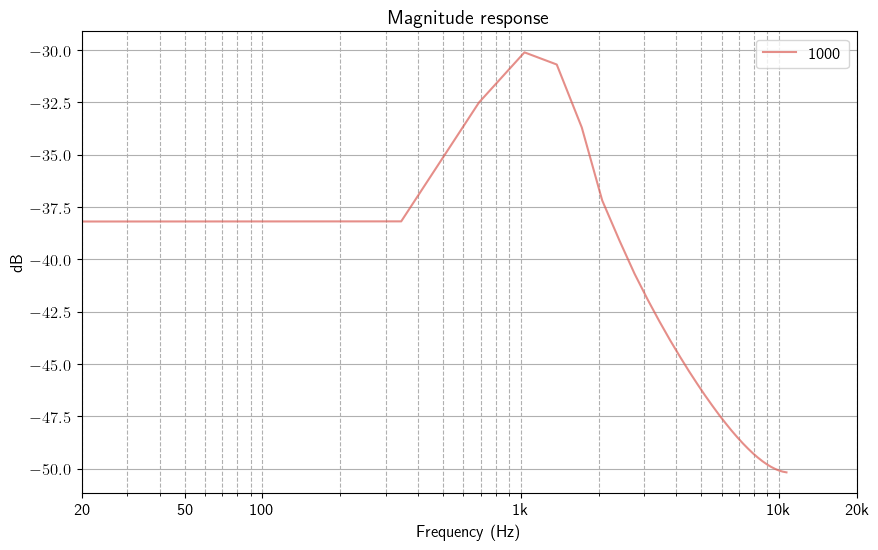

In [54]:
nh = GammatoneFilterbank(center_frequencies=center_frequencies,samplerate=samplerate,ftype='fir', numtaps=32, band_width_factor=1.0)
# nh = HearingModel(center_frequencies=center_frequencies,samplerate=samplerate, ftype='fir', numtaps=128)
# # nh = HearingModel(center_frequencies=center_frequencies,samplerate=samplerate)
nh(audio)


plot_gammabank(nh,samplerate=samplerate,center_frequencies=center_frequencies)

# # model(audio)
# nh = GammatoneFilterbank(center_frequencies=center_frequencies,samplerate=samplerate,ftype='fir', numtaps=32, band_width_factor=1.0)
# # nh = HearingModel(center_frequencies=center_frequencies,samplerate=samplerate, ftype='fir', numtaps=128)
# # # nh = HearingModel(center_frequencies=center_frequencies,samplerate=samplerate)
# nh(audio)


# plot_gammabank(nh,samplerate=samplerate,center_frequencies=center_frequencies)

# # model(audio)

In [42]:
import torchaudio

model = MyModel_v2(num_taps=128,samplerate=samplerate,center_frequencies=center_frequencies,band_width_factor=5.0)

audio, samplerate = torchaudio.load(r"..\audio\examples\Human_voice\1.wav")
batch_size = 1
n_channels, n_samples = audio.shape
audio = audio.reshape((batch_size,n_channels,n_samples))

x, y = model(audio)

audio_play(batch_2_np(x),samplerate=samplerate)
audio_play(batch_2_np(y),samplerate=samplerate)


input audio


normal hearing  output


impaired output


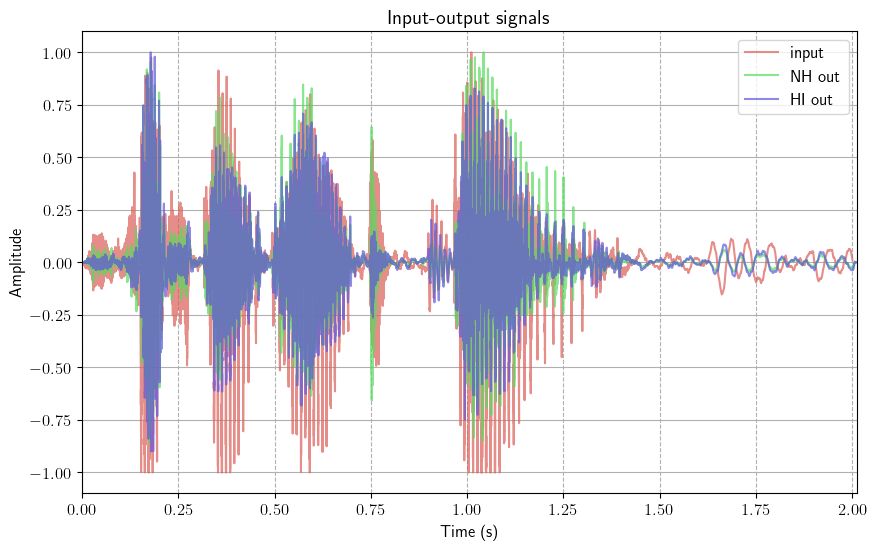

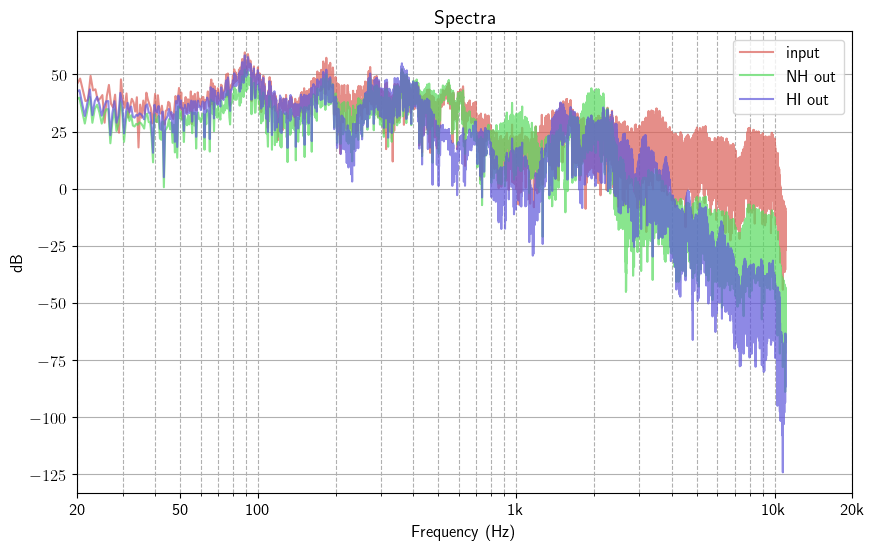

In [44]:
x_noise = torch.randn(n_batch, n_channels, n_samples)  # Input of length 10, all zeros
x_noise[:,:,10000:] = 0.0  # Input of length 10, all zeros
x_d = torch.zeros(n_batch, n_channels, n_samples)  # Input of length 10, all zeros
x_d[:, :, 0:1000] = 1.0  # Impulse

# choose which signal to excite with
x = audio

# out_NH, out_HI = model(xnoise)
out_NH, out_HI = model(x)

print("input audio")
audio_play(batch_2_np(x),samplerate)
print("normal hearing  output")
audio_play(batch_2_np(out_NH),samplerate)
print("impaired output")
audio_play(batch_2_np(out_HI),samplerate)


signals = [
    batch_2_np(x) / max(batch_2_np(x)),
    batch_2_np(out_NH) / max(batch_2_np(out_NH)),
    batch_2_np(out_HI) / max(batch_2_np(out_HI)),
]

plot_time_and_spec(signals,samplerate=samplerate,
                   labels= ['input','NH out', 'HI out'])

In [45]:
gt = design_gammatone(center_frequencies,samplerate,'fir')

TypeError: float() argument must be a string or a real number, not 'list'